Stefan Pophristic + Boxuan Li
May 1st, 2025
Information Theory Project

After our Meeting with Noga on April 30th, we agreed to first try to implement a simpler information bottlneck calcuation to test whether Mandarin classifiers are optimal. 

The general IB Formula is:
$$
  min I(X;T) - \beta I(T;Y)
$$

Noga suggested the quantify our analysis as follows:
$$
I_{q}(N;W) + \beta \mathbb{E}[d(N; N_{w})]
$$

N = the set of all Nouns to which MW can refer to
W = the set of all MW


**The Compression Term**

The mutual information between N and W can be computed using the normal mutual information calculations:
$$
I_{q}(N;W) = \sum_{n\in N}\sum_{w \in W} p(n,w) log\frac{p(n,w)}{p(n)p(w)}
$$
$$
p(n, w) = p(n|w)p(w)
$$

p(n) = probbability of a noun in the corpus
p(w) = probability of a MW in the corpus
p(n|w) = probability of the noun given a MW


**The Reconstruction Term**

Also known as the reconstruction error. 

$N_{w}$ = The set of centroids in the semantic vector space of all nouns, grouped by MW

$d$ is a function that measures the reconstruction error. It could be something like KL divergence or mean square errors. In our case, we will just use the cosine similarity (i.e. distance in semantic vector space) between an N and its associated MW. 

# Parameters

In [1]:
import pandas as pd
import fasttext
import os 
from gensim.models import KeyedVectors
import seaborn as sns

import numpy as np
from numpy import dot
from numpy.linalg import norm

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


In [4]:
# Import files 

noun_mw_df = pd.read_csv("/Volumes/Server/SHARED/Corpora/Universal_Dependencies/2025_InformationTheory_Project/chinese_noun_mw.csv")

In [5]:
noun_mw_df.head()

,Noun,MW,Count_Pre,Count_Post
0,上午,日,1,0
1,下半,局,1,0
2,下旬,年,1,0
3,下旬,月,2,0
4,下颌,个,1,0


In [6]:
all_nouns = noun_mw_df["Noun"].unique()
all_mw    = noun_mw_df["MW"].unique()

print(f"Number of unique nouns: {len(all_nouns)}")
print(f"Number of unique mw: {len(all_mw)}")

Number of unique nouns: 847
Number of unique mw: 110


In [7]:
mw_summary_df = noun_mw_df.groupby('MW')['Count_Pre'].sum().reset_index()
mw_summary_df = mw_summary_df.sort_values(by='Count_Pre', ascending=False)

In [8]:
mw_summary_df

,MW,Count_Pre
2,个,547
50,年,517
64,月,373
84,种,129
74,次,69
...,...,...
12,分,1
14,匹,1
15,双,1
16,口,1


In [66]:
count_eq_1 = (mw_summary_df['Count_Pre'] == 1).sum()
count_eq_2 = (mw_summary_df['Count_Pre'] == 2).sum()
count_eq_3 = (mw_summary_df['Count_Pre'] == 3).sum()

print(f"Number of MW with only 1 noun: {count_eq_1}")
print(f"Number of MW with only 2 noun: {count_eq_2}")
print(f"Number of MW with only 3 noun: {count_eq_3}")

Number of MW with only 1 noun: 38
Number of MW with only 2 noun: 10
Number of MW with only 3 noun: 15


In [67]:
# Import Mandarin Fasttext
model = KeyedVectors.load_word2vec_format('/Volumes/server/SHARED/Corpora/FastText/Mandarin/cc.zh.300.vec', binary=False)

In [68]:
# if you look up an individual word， it will return the semantic vector
model["人"]

array([-1.419e-01,  7.040e-02,  4.526e-01, -1.260e-01,  4.830e-02,
        1.430e-02, -1.023e-01, -5.760e-02,  4.770e-02,  5.000e-04,
        1.910e-02,  9.650e-02,  4.850e-02, -1.361e-01,  3.510e-02,
        5.050e-02, -3.300e-03, -3.230e-02, -2.930e-02, -9.220e-02,
        1.740e-02, -3.000e-03, -1.290e-02, -1.780e-02,  1.045e-01,
       -4.590e-02,  1.355e-01,  5.930e-02,  3.780e-02,  3.700e-02,
       -1.330e-02, -2.950e-02, -6.500e-03,  1.880e-02, -2.005e-01,
       -4.630e-02, -7.030e-02, -1.343e-01, -2.600e-02,  3.700e-03,
       -7.230e-02, -7.980e-02,  6.500e-03, -1.563e-01, -1.182e-01,
        6.890e-02, -5.220e-02, -2.920e-02,  8.610e-02,  3.390e-02,
       -7.130e-02,  7.220e-02,  2.830e-02, -9.450e-02, -3.400e-03,
        4.360e-02, -9.400e-03,  2.460e-02, -2.100e-02, -7.980e-02,
       -7.920e-02, -1.823e-01, -7.840e-02,  3.750e-02,  1.560e-02,
        2.800e-03, -4.840e-02,  5.720e-02, -1.470e-02,  3.910e-02,
       -4.390e-02,  5.420e-02,  3.630e-02, -4.700e-02,  2.398e

# Create Semantic Clusters

In [69]:
# Add semantic vectors for each Noun to master df 

noun_vectors = []

for noun in noun_mw_df["Noun"]:
    try:
        vector = model[noun]
    except:
        vector = []
    noun_vectors.append(vector)



In [70]:
noun_mw_df["noun_semantics"] = noun_vectors

In [71]:
noun_mw_df.head()

,Noun,MW,Count_Pre,Count_Post,noun_semantics
0,上午,日,1,0,"[0.0198, -0.0406, 0.4887, -0.0755, -0.038, 0.1..."
1,下半,局,1,0,"[0.0306, 0.0379, 0.4806, 0.0162, 0.1408, -0.12..."
2,下旬,年,1,0,"[0.1047, -0.0735, 0.5682, 0.056, 0.0032, -0.05..."
3,下旬,月,2,0,"[0.1047, -0.0735, 0.5682, 0.056, 0.0032, -0.05..."
4,下颌,个,1,0,"[0.3003, -0.3533, 0.2598, -0.1818, 0.2832, -0...."


In [72]:
# Re-arrange dataframe to have arrays of nouns with their corresponding MW 
# We do this for easy computation of centroids 

noun_dict = noun_mw_df.groupby('MW')['Noun'].apply(list).to_dict()
noun_dict

{'世': ['喇嘛', '活佛'],
 '世纪': ['中叶', '前期', '后期', '年代', '文学', '早期', '期'],
 '个': ['下颌',
  '世纪',
  '个',
  '中学',
  '中心',
  '主意',
  '主角',
  '义项',
  '乐团',
  '乡',
  '乡镇',
  '事实',
  '井字',
  '产物',
  '亲王',
  '人',
  '人物',
  '人选',
  '从句',
  '仪式',
  '任务',
  '企业',
  '会',
  '传统',
  '传说',
  '伯爵',
  '例子',
  '保障',
  '俱乐部',
  '儿子',
  '元件',
  '元素',
  '公司',
  '公园',
  '公国',
  '公寓',
  '公式',
  '公爵',
  '关系',
  '军团',
  '冠军',
  '分支',
  '分站',
  '分类',
  '别名',
  '副本',
  '力量',
  '化石',
  '区划',
  '区域',
  '单位',
  '历史',
  '原因',
  '原子',
  '原理',
  '县',
  '参考',
  '反例',
  '反应',
  '受体',
  '变数',
  '变调',
  '叛徒',
  '名号',
  '名字',
  '名词',
  '吻',
  '哥哥',
  '因素',
  '团体',
  '国家',
  '圆弧',
  '地区',
  '地方',
  '地点',
  '城市',
  '城镇',
  '堂区',
  '堂弟',
  '壮汉',
  '声道',
  '夜晚',
  '头槌',
  '奖品',
  '女儿',
  '女眷',
  '好手',
  '妹妹',
  '姐妹',
  '姐姐',
  '婚姻',
  '子夜',
  '字',
  '字母',
  '孤岛',
  '学位',
  '学期',
  '学科',
  '学院',
  '孩子',
  '宇宙',
  '宗教',
  '定理',
  '宝藏',
  '实体',
  '家庭',
  '家族',
  '对象',
  '导演',
  '导航',
  '小体',
  '小孩',
  '小岛',
  '小时',
  '小组',
  '小调',
  '

In [73]:
# Calculate centroids
# Note that this noramlizes the centroids (don't fully understand that but chatgpt recommends it)

mw_centroids = {}

for mw, words in noun_dict.items():
    vectors = []
    for word in words:
        if word in model:
            vectors.append(model[word])
    if vectors:
        centroid = np.mean(vectors, axis=0)
        centroid = centroid / np.linalg.norm(centroid) # Centroid Normalization line
        mw_centroids[mw] = centroid


In [74]:
# Add centroids back into the main df
noun_mw_df['MW_centroid'] = noun_mw_df['MW'].map(mw_centroids)


In [75]:
noun_mw_df.head()

,Noun,MW,Count_Pre,Count_Post,noun_semantics,MW_centroid
0,上午,日,1,0,"[0.0198, -0.0406, 0.4887, -0.0755, -0.038, 0.1...","[0.01849203, -0.01423676, 0.28674656, -0.01710..."
1,下半,局,1,0,"[0.0306, 0.0379, 0.4806, 0.0162, 0.1408, -0.12...","[0.010074613, 0.012478034, 0.15823069, 0.00533..."
2,下旬,年,1,0,"[0.1047, -0.0735, 0.5682, 0.056, 0.0032, -0.05...","[0.012088664, 0.029345127, 0.3760401, -0.04587..."
3,下旬,月,2,0,"[0.1047, -0.0735, 0.5682, 0.056, 0.0032, -0.05...","[0.038568486, 0.020332241, 0.3018137, -0.00249..."
4,下颌,个,1,0,"[0.3003, -0.3533, 0.2598, -0.1818, 0.2832, -0....","[-0.0051299897, 0.01669156, 0.34969214, -0.029..."


In [76]:
# Calculate Cosine similarity between the given noun and the MW
# Higher value = more similar

def cosine_similarity(vec1, vec2):
    if (vec1 is None or vec2 is None or 
        len(vec1) != 300 or len(vec2) != 300):
        return np.nan
    return dot(vec1, vec2) / (norm(vec1) * norm(vec2))
    
noun_mw_df['cosine_sim'] = noun_mw_df.apply(
    lambda row: cosine_similarity(row['noun_semantics'], row['MW_centroid']),
    axis=1
)


In [77]:
noun_mw_df.head()

,Noun,MW,Count_Pre,Count_Post,noun_semantics,MW_centroid,cosine_sim
0,上午,日,1,0,"[0.0198, -0.0406, 0.4887, -0.0755, -0.038, 0.1...","[0.01849203, -0.01423676, 0.28674656, -0.01710...",0.753960
1,下半,局,1,0,"[0.0306, 0.0379, 0.4806, 0.0162, 0.1408, -0.12...","[0.010074613, 0.012478034, 0.15823069, 0.00533...",1.000000
2,下旬,年,1,0,"[0.1047, -0.0735, 0.5682, 0.056, 0.0032, -0.05...","[0.012088664, 0.029345127, 0.3760401, -0.04587...",0.539342
3,下旬,月,2,0,"[0.1047, -0.0735, 0.5682, 0.056, 0.0032, -0.05...","[0.038568486, 0.020332241, 0.3018137, -0.00249...",0.645733
4,下颌,个,1,0,"[0.3003, -0.3533, 0.2598, -0.1818, 0.2832, -0....","[-0.0051299897, 0.01669156, 0.34969214, -0.029...",0.427536


/var/folders/0f/7mr42p3n3mxc5z1g5q3267p81ryl0h/T/ipykernel_54714/3270163396.py:30: UserWarning: Glyph 20010 (\N{CJK UNIFIED IDEOGRAPH-4E2A}) missing from current font.
  plt.tight_layout()
/Users/sp6961/miniconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20010 (\N{CJK UNIFIED IDEOGRAPH-4E2A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


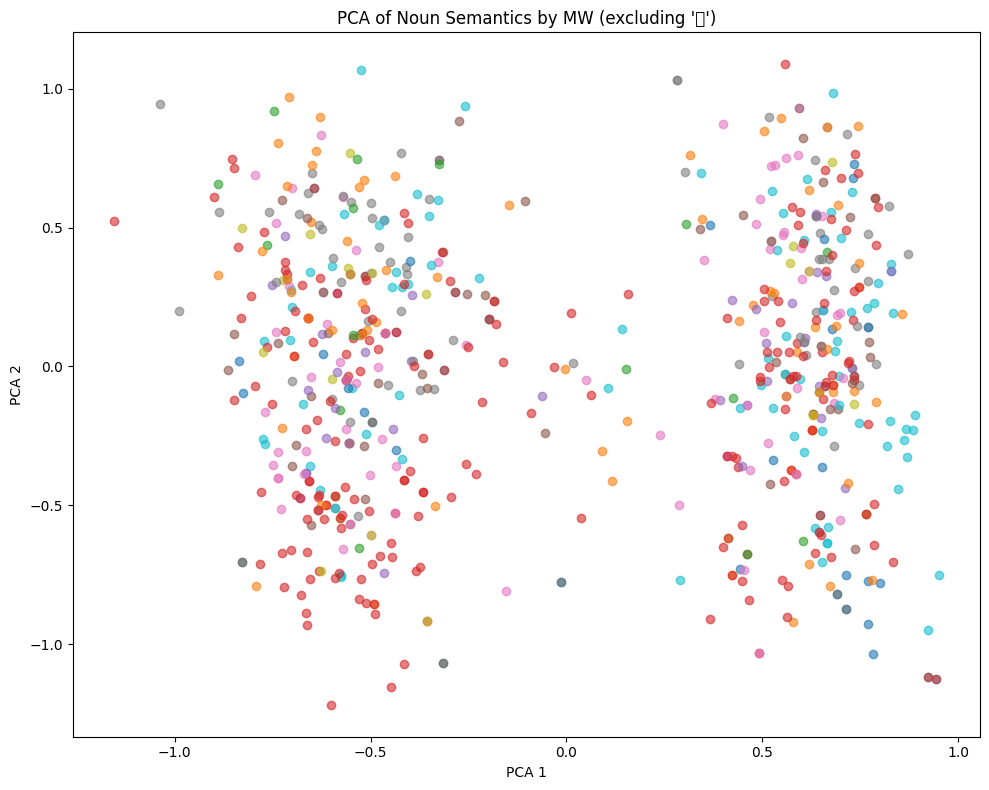

In [78]:

# 1. Filter out the rows where MW == "个"
plot_df = noun_mw_df[noun_mw_df['MW'] != "个"].copy()

# 2. Drop rows with missing vectors or invalid dimensions
plot_df = plot_df.dropna(subset=['noun_semantics'])
plot_df = plot_df[plot_df['noun_semantics'].apply(lambda x: len(x) == 300)]

# 3. Stack vectors into a matrix for PCA
X = np.vstack(plot_df['noun_semantics'].values)

# 4. Run PCA (using 2 components for 2D visualization)
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

# 5. Add PCA results to DataFrame
plot_df['pca_x'] = X_2d[:, 0]
plot_df['pca_y'] = X_2d[:, 1]

# 6. Plot
plt.figure(figsize=(10, 8))
groups = plot_df.groupby('MW')

for name, group in groups:
    plt.scatter(group['pca_x'], group['pca_y'], label=name, alpha=0.6)

# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='MW')
plt.title("PCA of Noun Semantics by MW (excluding '个')")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.tight_layout()
plt.show()

/var/folders/0f/7mr42p3n3mxc5z1g5q3267p81ryl0h/T/ipykernel_54714/2960682451.py:37: UserWarning: Glyph 20010 (\N{CJK UNIFIED IDEOGRAPH-4E2A}) missing from current font.
  plt.tight_layout()
/var/folders/0f/7mr42p3n3mxc5z1g5q3267p81ryl0h/T/ipykernel_54714/2960682451.py:37: UserWarning: Glyph 19990 (\N{CJK UNIFIED IDEOGRAPH-4E16}) missing from current font.
  plt.tight_layout()
/var/folders/0f/7mr42p3n3mxc5z1g5q3267p81ryl0h/T/ipykernel_54714/2960682451.py:37: UserWarning: Glyph 32426 (\N{CJK UNIFIED IDEOGRAPH-7EAA}) missing from current font.
  plt.tight_layout()
/var/folders/0f/7mr42p3n3mxc5z1g5q3267p81ryl0h/T/ipykernel_54714/2960682451.py:37: UserWarning: Glyph 20195 (\N{CJK UNIFIED IDEOGRAPH-4EE3}) missing from current font.
  plt.tight_layout()
/var/folders/0f/7mr42p3n3mxc5z1g5q3267p81ryl0h/T/ipykernel_54714/2960682451.py:37: UserWarning: Glyph 20214 (\N{CJK UNIFIED IDEOGRAPH-4EF6}) missing from current font.
  plt.tight_layout()
/var/folders/0f/7mr42p3n3mxc5z1g5q3267p81ryl0h/T/ipyker

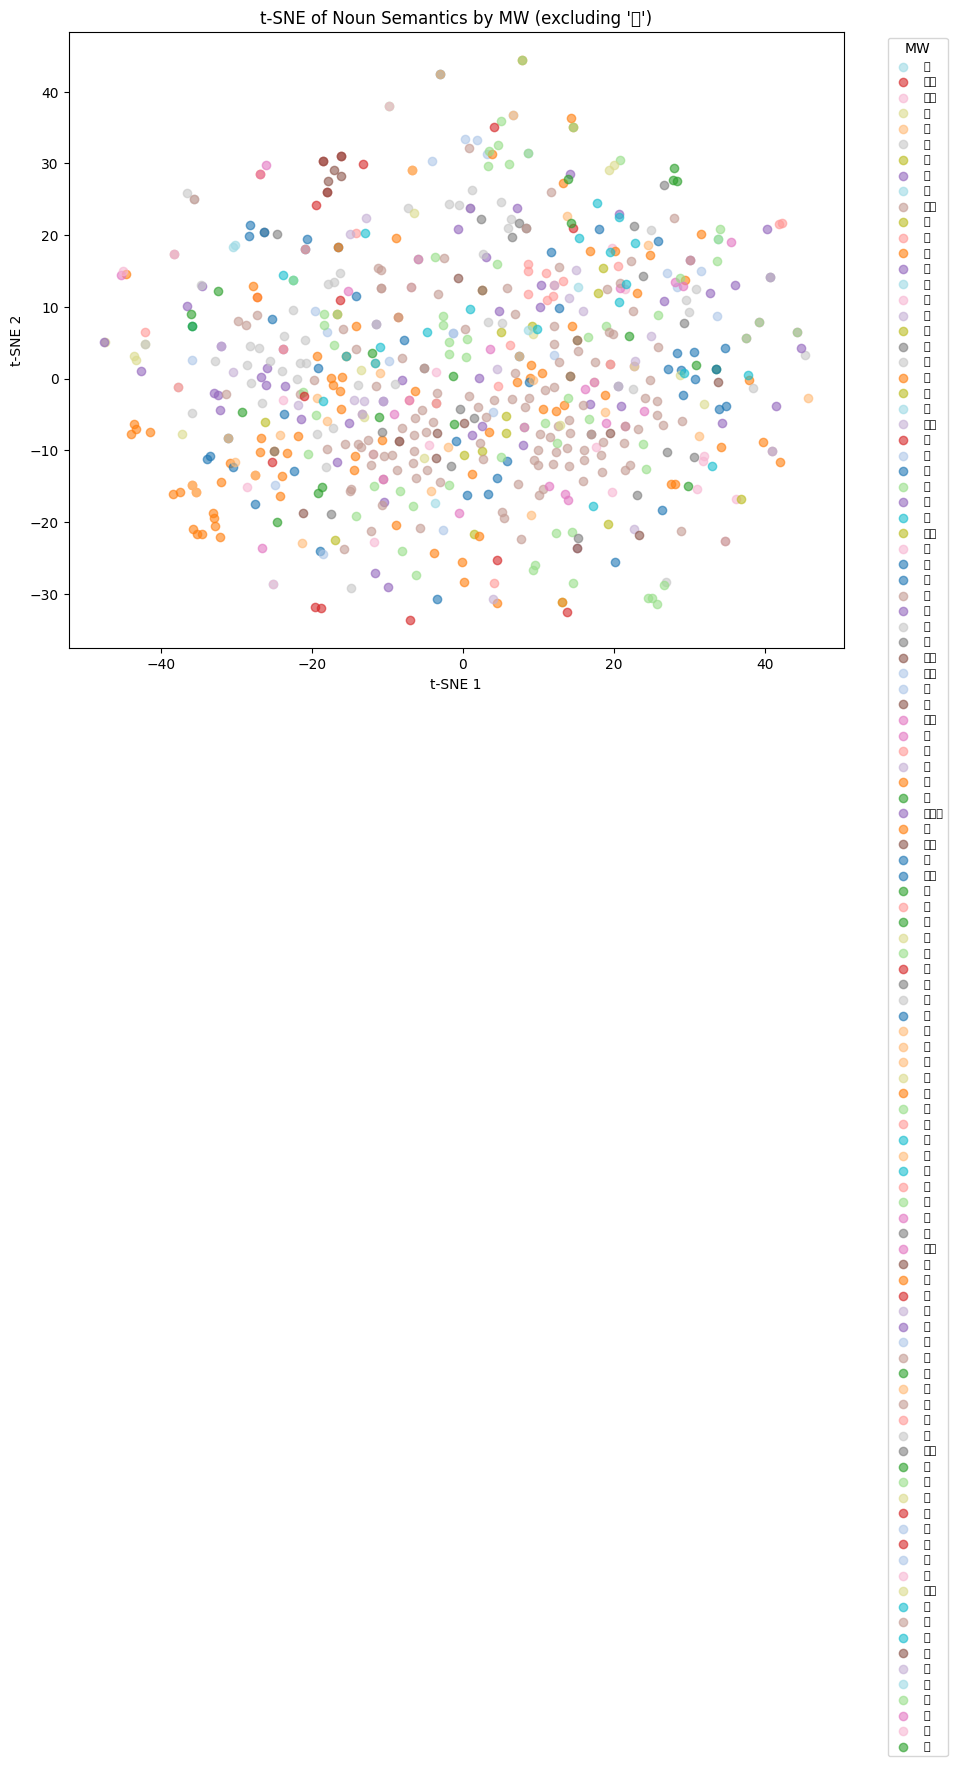

In [79]:

# 1. Filter out the rows where MW == "个"
plot_df = noun_mw_df[noun_mw_df['MW'] != "个"].copy()

# 2. Drop rows with missing vectors or invalid dimensions
plot_df = plot_df.dropna(subset=['noun_semantics'])
plot_df = plot_df[plot_df['noun_semantics'].apply(lambda x: len(x) == 300)]  # Ensure vectors have the correct length

# 3. Stack vectors into a matrix for t-SNE
X = np.vstack(plot_df['noun_semantics'].values)

# 4. Run t-SNE (using 2 components for 2D visualization)
tsne = TSNE(n_components=2, random_state=42, init='pca', perplexity=30)
X_2d = tsne.fit_transform(X)

# 5. Add t-SNE results to DataFrame
plot_df['tsne_x'] = X_2d[:, 0]
plot_df['tsne_y'] = X_2d[:, 1]

# 6. Get a list of unique MWs and assign a color palette
unique_mws = plot_df['MW'].unique()
colors = sns.color_palette("tab20", len(unique_mws))  # Use a larger, distinct colormap

# 7. Create a dictionary to map MWs to colors
mw_to_color = {mw: colors[i % len(colors)] for i, mw in enumerate(unique_mws)}  # Ensures uniqueness with modulo

# 8. Plot
plt.figure(figsize=(10, 8))

# Loop through MW groups and plot with unique color
for name, group in plot_df.groupby('MW'):
    plt.scatter(group['tsne_x'], group['tsne_y'], label=name, alpha=0.6, color=mw_to_color[name])

plt.title("t-SNE of Noun Semantics by MW (excluding '个')")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='MW', fontsize=8)
plt.tight_layout()
plt.show()

/var/folders/0f/7mr42p3n3mxc5z1g5q3267p81ryl0h/T/ipykernel_54714/867038764.py:44: UserWarning: Glyph 20010 (\N{CJK UNIFIED IDEOGRAPH-4E2A}) missing from current font.
  plt.tight_layout()
/Users/sp6961/miniconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20010 (\N{CJK UNIFIED IDEOGRAPH-4E2A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


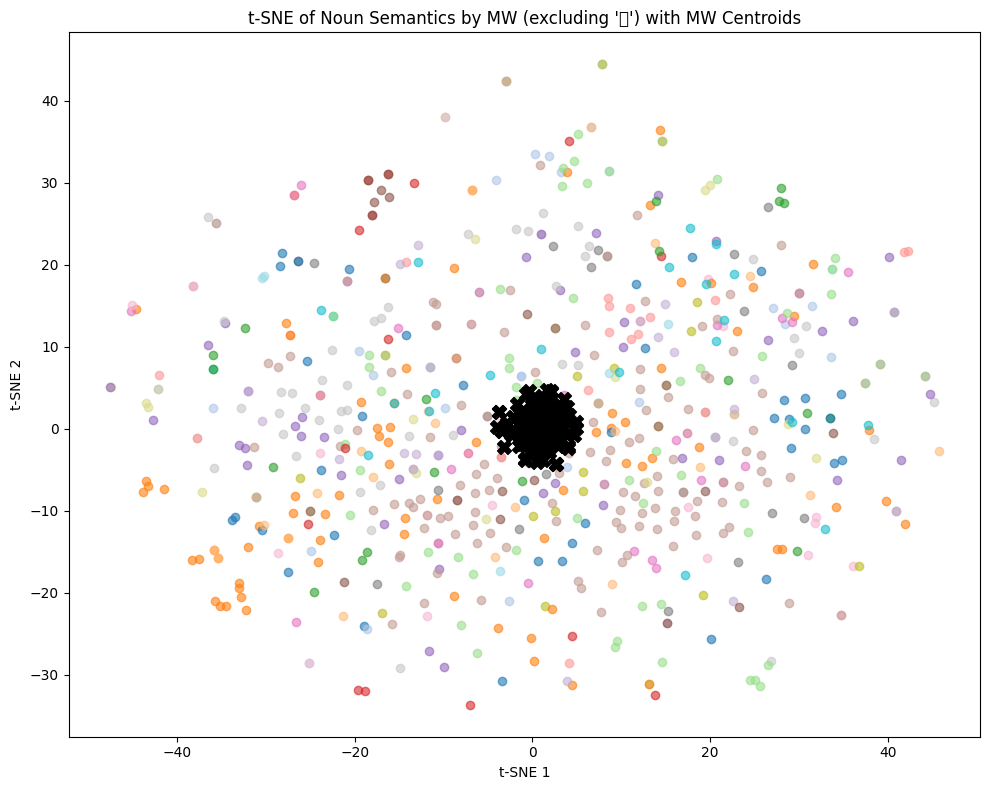

In [80]:

# 1. Filter out the rows where MW == "个"
plot_df = noun_mw_df[noun_mw_df['MW'] != "个"].copy()

# 2. Drop rows with missing vectors or invalid dimensions
plot_df = plot_df.dropna(subset=['noun_semantics'])
plot_df = plot_df[plot_df['noun_semantics'].apply(lambda x: len(x) == 300)]  # Ensure vectors have the correct length

# 3. Stack vectors into a matrix for t-SNE
X = np.vstack(plot_df['noun_semantics'].values)

# 4. Run t-SNE (using 2 components for 2D visualization)
tsne = TSNE(n_components=2, random_state=42, init='pca', perplexity=30)
X_2d = tsne.fit_transform(X)

# 5. Add t-SNE results to DataFrame
plot_df['tsne_x'] = X_2d[:, 0]
plot_df['tsne_y'] = X_2d[:, 1]

# 6. Get a list of unique MWs and assign a color palette
unique_mws = plot_df['MW'].unique()
colors = sns.color_palette("tab20", len(unique_mws))  # Use a larger, distinct colormap

# 7. Create a dictionary to map MWs to colors
mw_to_color = {mw: colors[i % len(colors)] for i, mw in enumerate(unique_mws)}  # Ensures uniqueness with modulo

# 8. Plotting words (noun semantics)
plt.figure(figsize=(10, 8))

for name, group in plot_df.groupby('MW'):
    plt.scatter(group['tsne_x'], group['tsne_y'], label=name, alpha=0.6, color=mw_to_color[name])

# 9. Plotting MW centroids (use 'mw_centroid' column from the DataFrame)
centroid_tsne = np.vstack(plot_df.groupby('MW')['MW_centroid'].first().values)  # Getting the centroids
centroid_tsne_2d = tsne.fit_transform(centroid_tsne)

# Plot the centroids
plt.scatter(centroid_tsne_2d[:, 0], centroid_tsne_2d[:, 1], marker='X', color='black', s=100, label='Centroids', edgecolor='k')

# Add legends and labels
plt.title("t-SNE of Noun Semantics by MW (excluding '个') with MW Centroids")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='MW', fontsize=8)
plt.tight_layout()
plt.show()

In [81]:
# Do PCA and plot

# Cosine Similarity

In [82]:
# Calculate Cosine Similarties. 

In [83]:
from sklearn.metrics import silhouette_score

# Stack noun vectors
X = np.vstack(plot_df['noun_semantics'].values)

# Convert MWs to numeric cluster labels
from sklearn.preprocessing import LabelEncoder
labels = LabelEncoder().fit_transform(plot_df['MW'])

# Compute silhouette score
score = silhouette_score(X, labels)
print(f"Silhouette Score: {score:.3f}")


Silhouette Score: -0.165


In [84]:
# Pretty bad score, in other words, teh clusters are super overlapping

In [85]:
from scipy.spatial.distance import cosine

intra_dists = []
inter_dists = []

for i, row in plot_df.iterrows():
    noun_vec = row['noun_semantics']
    mw = row['MW']
    centroid = row['MW_centroid']
    
    # Intra-cluster distance
    intra = cosine(noun_vec, centroid)
    intra_dists.append(intra)
    
    # Inter-cluster distance (to centroids of other MWs)
    for other_mw, other_centroid in plot_df.groupby('MW')['MW_centroid'].first().items():
        if other_mw != mw:
            inter = cosine(noun_vec, other_centroid)
            inter_dists.append(inter)

# Compare means
import numpy as np
print(f"Mean Intra-cluster Cosine Distance: {np.mean(intra_dists):.3f}")
print(f"Mean Inter-cluster Cosine Distance: {np.mean(inter_dists):.3f}")


Mean Intra-cluster Cosine Distance: 0.389
Mean Inter-cluster Cosine Distance: 0.747


According to chat-gpt:
intra-cluaster should be low (0-0.3)
inter-cluster should be high (>0.5
a gap of bigger than 0.2 means a mennaingful clustering 

In [86]:
from scipy.stats import ttest_ind
t_stat, p_val = ttest_ind(intra_dists, inter_dists, equal_var=False)
print(f"T-test p-value: {p_val:.5f}")

T-test p-value: 0.00000


In [87]:
noun_mw_df.to_csv('output/noun_mw_cosineSim.csv')